In [2]:

# import basic modules
import sys
import os
import time
import numpy as np
from tqdm import tqdm
import gc
import torch
import argparse
import skimage.transform

# import custom modules
code_dir = '/user_data/mmhender/imStat/code/'
sys.path.append(code_dir)
from feature_extraction import texture_statistics_gabor, bdcn_features, sketch_token_features
from feature_extraction import texture_statistics_pyramid
from utils import nsd_utils, roi_utils, default_paths

from model_fitting import initialize_fitting as initialize_fitting
from model_fitting import arg_parser as arg_parser
from model_fitting import merge_features, fwrf_fit, fwrf_predict, reconstruct

fpX = np.float32
# device = initialize_fitting.init_cuda()
device = 'cpu:0'
# device = initialize_fitting.init_cuda()

In [16]:
fitting_type='pyramid_texture';
subject=1; volume_space = True; up_to_sess = 10;

n_ori = 4; n_sf = 4; nonlin_fn = False;  padding_mode = 'circular'; \
group_all_hl_feats = True; 

sample_batch_size = 50; voxel_batch_size = 100; \

zscore_features = True; zscore_in_groups = False; ridge = True; \
shuffle_images = False; random_images = False; random_voxel_data = False; \
do_fitting = True; use_precomputed_prfs = False; do_val = True; do_stack=True; \
do_varpart = True; do_roi_recons=False; do_voxel_recons=False; date_str = 0; \

shuff_rnd_seed = 301119; 
debug = True;

use_pca_st_feats = False; use_lda_st_feats = False; lda_discrim_type = None; \
do_pca_bdcn = True; use_pca_pyr_feats_ll = False; use_pca_pyr_feats_hl = False;\

min_pct_var = 99; max_pc_to_retain = 400; \
max_pc_to_retain_pyr_ll = 100; max_pc_to_retain_pyr_hl = 100;\
map_ind = -1; n_prf_sd_out = 2; mult_patch_by_prf = True; \
downsample_factor = 1.0; do_nms = False

In [17]:
# decide what voxels to use  
voxel_mask, voxel_index, voxel_roi, voxel_ncsnr, brain_nii_shape = roi_utils.get_voxel_roi_info(subject, \
                                                        volume_space, include_all=True, include_body=True)

sessions = np.arange(0,up_to_sess)
zscore_betas_within_sess = True
# get all data and corresponding images, in two splits. always fixed set that gets left out
trn_stim_data, trn_voxel_data, val_stim_data, val_voxel_data, \
        image_order, image_order_trn, image_order_val = nsd_utils.get_data_splits(subject, \
                                  sessions=sessions, image_inds_only = True, \
                                  voxel_mask=voxel_mask, volume_space=volume_space, \
                                  zscore_betas_within_sess=zscore_betas_within_sess, \
                              shuffle_images=shuffle_images, random_images=random_images, \
                                random_voxel_data=random_voxel_data)




Volume space: ROI defs are located at: /lab_data/tarrlab/common/datasets/NSD/nsddata/ppdata/subj01/func1pt8mm/roi

3794 voxels of overlap between kastner and prf definitions, using prf defs
unique values in retino labels:
[-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25.]
unique values in face labels:
[-1.  0.  1.  2.  3.  5.]
unique values in place labels:
[-1.  0.  1.  2.  3.]
unique values in body labels:
[-1.  0.  1.  2.  3.]
1987 voxels are defined (differently) in both retinotopic areas and category areas
0 voxels are defined (differently) in both face areas and place areas
490 voxels are defined (differently) in both face areas and body areas
158 voxels are defined (differently) in both place areas and body areas
Including all voxels that are defined within nsdgeneral mask, in addition to roi labels.

19738 voxels are defined across all areas, and will be used for analysis

Loading numerical label/name mappings for all

In [18]:
trn_stim_data = image_order_trn
val_stim_data = image_order_val

In [19]:
# More params for fitting
holdout_size, lambdas = initialize_fitting.get_fitting_pars(trn_voxel_data, zscore_features, ridge=ridge)
# Params for the spatial aspect of the model (possible pRFs)
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range) 

if use_precomputed_prfs:
    best_model_each_voxel = initialize_fitting.load_precomputed_prfs(fitting_type,subject)
    print(trn_voxel_data.shape)
    print(len(best_model_each_voxel))
    assert(len(best_model_each_voxel)==trn_voxel_data.shape[1])
else:
    best_model_each_voxel = None



Possible lambda values are:
[1.0000000e+00 4.2169652e+00 1.7782795e+01 7.4989418e+01 3.1622775e+02
 1.3335215e+03 5.6234131e+03 2.3713736e+04 1.0000000e+05]
most extreme RF positions:
[-0.55 -0.55  0.04]
[0.55       0.55       0.40000001]


In [20]:
# Set up the pyramid
compute_features = False
feature_types_exclude = []
_fmaps_fn = texture_statistics_pyramid.steerable_pyramid_extractor(pyr_height = n_sf, n_ori = n_ori)
# Initialize the "texture" model which builds on first level feature maps
_feature_extractor = texture_statistics_pyramid.texture_feature_extractor(_fmaps_fn,\
          sample_batch_size=sample_batch_size, \
          subject=subject, feature_types_exclude=feature_types_exclude, \
          n_prf_sd_out=n_prf_sd_out,\
          aperture=aperture, do_varpart = do_varpart, zscore_in_groups = zscore_in_groups,\
          group_all_hl_feats = group_all_hl_feats, compute_features = compute_features, \
          use_pca_feats_ll = use_pca_pyr_feats_ll, use_pca_feats_hl = use_pca_pyr_feats_hl, \
          min_pct_var = min_pct_var, max_pc_to_retain_ll = max_pc_to_retain_pyr_ll, \
          max_pc_to_retain_hl = max_pc_to_retain_pyr_hl, device=device)
feature_info = [_feature_extractor.feature_column_labels, _feature_extractor.feature_types_include]

Feature types to exclude from the model:
[]
Grouping lower level features:
['pixel_stats' 'mean_magnitudes' 'mean_realparts'
 'marginal_stats_lowpass_recons' 'variance_highpass_resid']
Grouping higher level features:
['magnitude_feature_autocorrs' 'lowpass_recon_autocorrs'
 'highpass_resid_autocorrs' 'magnitude_within_scale_crosscorrs'
 'real_within_scale_crosscorrs' 'magnitude_across_scale_crosscorrs'
 'real_imag_across_scale_crosscorrs'
 'real_spatshift_within_scale_crosscorrs'
 'real_spatshift_across_scale_crosscorrs']


In [123]:
add_bias=True
# determines whether to shuffle before separating the nested heldout data for lambda and param selection. 
# always using true.
shuffle=True 
debug=True
best_losses, best_lambdas, best_params, best_train_holdout_preds, holdout_trial_order = \
                    fit_fwrf_model(trn_stim_data, trn_voxel_data, \
                           _feature_extractor, models, \
                           lambdas, best_model_each_voxel = best_model_each_voxel, \
                           zscore=zscore_features, add_bias=add_bias, \
                           voxel_batch_size=voxel_batch_size, holdout_size=holdout_size, \
                           shuffle=shuffle, shuff_rnd_seed=shuff_rnd_seed, device=device, \
                           dtype=fpX, debug=debug)
trn_holdout_voxel_data_pred = best_train_holdout_preds

dtype = <class 'numpy.float32'>
device = cpu:0
trn_size = 6122 (90.0%)
Seeding random number generator: seed is 301119
Initializing for fitting
Clearing precomputed features from memory.
will z-score each column
---------------------------------------


Getting features for prf 170: [x,y,sigma] is [0.03 -0.09 0.0400]
Loading pre-computed features for models [150 - 199] from /user_data/mmhender/features/pyramid_texture/S1_features_each_prf_4ori_4sf.h5py
Took 77.80113 seconds to load file
Size of features array for this batch is:
(6803, 641, 50)
Index into batch for prf 170: 20
Size of features array for this image set and prf is:
(6803, 641)
Final size of features concatenated is [6803 x 641]
Feature types included are:
['pixel_stats', 'mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', 'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', 'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'ma

In [22]:
best_params[1][0,0:10,0]

array([ 0.0035769 ,  0.00064432,  0.00058653, -0.00151202,  0.00334878,
       -0.00507672, -0.00295943, -0.00209879, -0.0013614 , -0.00056575],
      dtype=float32)

In [33]:
vind = 19645
best_params[5][vind,0]

171

In [125]:

val_cc, val_r2, val_voxel_data_pred  = \
    validate_fwrf_model(best_params, models, val_voxel_data, val_stim_data, \
             _feature_extractor, zscore=zscore_features, sample_batch_size=sample_batch_size, \
                                 voxel_batch_size=voxel_batch_size, debug=debug, dtype=fpX)


will z-score each column
Clearing precomputed features from memory.
Getting features for prf 170: [x,y,sigma] is [0.03 -0.09 0.0400]
Loading pre-computed features for models [150 - 199] from /user_data/mmhender/features/pyramid_texture/S1_features_each_prf_4ori_4sf.h5py
Took 77.00901 seconds to load file
Size of features array for this batch is:
(697, 641, 50)
Index into batch for prf 170: 20
Size of features array for this image set and prf is:
(697, 641)
Final size of features concatenated is [697 x 641]
Feature types included are:
['pixel_stats', 'mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', 'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', 'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', 'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']
Final size of features concatenate

In [126]:
val_r2[vind,0]

-0.30486882

In [44]:

val_cc_OLD, val_r2_OLD, val_voxel_data_pred_OLD  = \
    validate_fwrf_model_OLD(best_params, models, val_voxel_data, val_stim_data, \
             _feature_extractor, sample_batch_size=sample_batch_size, \
                                 voxel_batch_size=voxel_batch_size, debug=debug, dtype=fpX)


Clearing precomputed features from memory.
Getting features for prf 170: [x,y,sigma] is [0.03 -0.09 0.0400]
Loading pre-computed features for models [150 - 199] from /user_data/mmhender/features/pyramid_texture/S1_features_each_prf_4ori_4sf.h5py
Took 80.38927 seconds to load file
Size of features array for this batch is:
(697, 641, 50)
Index into batch for prf 170: 20
Size of features array for this image set and prf is:
(697, 641)
Final size of features concatenated is [697 x 641]
Feature types included are:
['pixel_stats', 'mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', 'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', 'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', 'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']
Final size of features concatenated is [697 x 641]
Final si

In [37]:
val_r2[vind,0]

-14.152167

In [45]:
val_r2_OLD[vind,0]

-0.30486882

In [14]:
out = torch.load('/user_data/mmhender/imStat/model_fits/S01/texture_pyramid_ridge_4ori_4sf/Oct-19-2021_1128_52/all_fit_params')



In [15]:
out['best_params'][1][0,0:10,0]

array([ 0.01171559,  0.01568925, -0.02228238, -0.01057173,  0.00859173,
       -0.00289951, -0.02203399,  0.00166547,  0.00022474, -0.01879792],
      dtype=float32)

In [50]:
prf_models=models;
voxel_data = val_voxel_data
images = val_stim_data
zscore=True
dtype=fpX

In [51]:
params = best_params
device = _feature_extractor.device

n_trials, n_voxels = len(images), len(params[0])
n_prfs = prf_models.shape[0]
n_features = params[1].shape[1]  
n_voxels = np.shape(voxel_data)[1]

best_models, weights, bias, features_mt, features_st, best_model_inds = params
masks, partial_version_names = _feature_extractor.get_partial_versions()
masks = np.transpose(masks)    
n_features_max = _feature_extractor.max_features
n_partial_versions = len(partial_version_names)

if zscore:
    if hasattr(_feature_extractor, 'zgroup_labels') and \
                    _feature_extractor.zgroup_labels is not None:
        zscore_in_groups = True
        zgroup_labels = _feature_extractor.zgroup_labels
        print('will z-score columns in groups')
    else:
        zscore_in_groups = False
        print('will z-score each column')
else:
    print('will not z-score')

# val_cc is the correlation coefficient bw real and predicted responses across trials, for each voxel.
val_cc  = np.zeros(shape=(n_voxels, n_partial_versions), dtype=dtype)
val_r2 = np.zeros(shape=(n_voxels, n_partial_versions), dtype=dtype)

pred_models = np.full(fill_value=0, shape=(n_trials, n_features_max, n_prfs), dtype=dtype)
feature_inds_defined_each_prf = np.full(fill_value=0, shape=(n_features_max, n_prfs), dtype=bool)

# Saving full trial-by-trial predictions for each voxel, each partial model.
# Need these for stacking.
pred_voxel_data = np.full(fill_value=0, shape=(n_trials, n_voxels, n_partial_versions), dtype=dtype)


will z-score each column


In [58]:
pred_models_OLD = np.full(fill_value=0, shape=(n_trials, n_features_max, n_prfs), dtype=dtype)
feature_inds_defined_each_prf_OLD = np.full(fill_value=0, shape=(n_features_max, n_prfs), dtype=bool)


In [107]:
np.where(best_params[5]==171)[0]

array([19601, 19601, 19601, 19603, 19603, 19603, 19604, 19604, 19604,
       19605, 19605, 19605, 19608, 19608, 19608, 19612, 19612, 19612,
       19613, 19613, 19613, 19614, 19614, 19614, 19616, 19616, 19616,
       19617, 19617, 19617, 19619, 19619, 19619, 19623, 19623, 19623,
       19625, 19625, 19625, 19626, 19626, 19626, 19627, 19627, 19627,
       19628, 19628, 19628, 19630, 19630, 19630, 19631, 19631, 19631,
       19633, 19633, 19633, 19636, 19636, 19636, 19637, 19637, 19637,
       19639, 19639, 19639, 19640, 19640, 19640, 19641, 19641, 19641,
       19642, 19642, 19642, 19645, 19645, 19645, 19646, 19646, 19646,
       19647, 19647, 19647, 19648, 19648, 19648, 19649, 19649, 19649,
       19650, 19650, 19650, 19657, 19657, 19657, 19658, 19658, 19658,
       19659, 19659, 19659, 19660, 19660, 19660, 19663, 19663, 19663,
       19670, 19670, 19670, 19671, 19671, 19671, 19682, 19682, 19682,
       19683, 19683, 19683, 19697, 19697, 19697, 19699, 19699, 19699,
       19700, 19700,

In [108]:
vind

19645

In [110]:
best_params[3][vind,0:10]

array([ 0.43302217,  0.02848657,  0.11009788, 10.340308  ,  0.0229753 ,
        0.968343  ,  3.0171273 ,  2.9187593 ,  3.4589174 ,  2.9291668 ],
      dtype=float32)

In [112]:
tiled_mean = np.tile(features_mt[vind,:], [n_trials, 1])
tiled_mean.shape

(697, 641)

In [132]:
# new method

_feature_extractor.clear_big_features()

mm = 171
vind = 19645
# for mm in range(170,172):
#         for mm in range(n_prfs):
#             if mm>1 and debug:
#                 break
print('Getting features for prf %d: [x,y,sigma] is [%.2f %.2f %.4f]'%(mm, prf_models[mm,0],  prf_models[mm,1],  prf_models[mm,2] ))
# all_feat_concat is size [ntrials x nfeatures]
# nfeatures may be less than n_features_max, because n_features_max is the largest number possible for any pRF.
# feature_inds_defined is length max_features, and tells which of the features in max_features are includes in features.
all_feat_concat, feature_inds_defined = _feature_extractor(images, prf_models[mm,:], mm, fitting_mode=False)

all_feat_concat = torch_utils.get_value(all_feat_concat)
if zscore:
    if zscore_in_groups:
        all_feat_concat = numpy_utils.zscore_in_groups(all_feat_concat, zgroup_labels)
    else:
        all_feat_concat_RAW = all_feat_concat
#         tiled_mean = np.tile(features_mt[vind,:], [n_trials, 1])
#         tiled_std = np.tile(features_st[vind,:], [n_trials, 1])
#         all_feat_concat = (all_feat_concat - tiled_mean)/tiled_std
        all_feat_concat = scipy.stats.zscore(all_feat_concat, axis=0)
    # if any entries in std are zero or nan, this gives bad result - fix these now.
    # these bad entries will also be zero in weights, so doesn't matter. 
    # just want to avoid nans.
    all_feat_concat[np.isnan(all_feat_concat)] = 0.0 
    all_feat_concat[np.isinf(all_feat_concat)] = 0.0 

pred_models[:,feature_inds_defined,mm] = all_feat_concat
feature_inds_defined_each_prf[:,mm] = feature_inds_defined

_feature_extractor.clear_big_features()


Clearing precomputed features from memory.
Getting features for prf 171: [x,y,sigma] is [0.09 -0.09 0.0400]
Loading pre-computed features for models [150 - 199] from /user_data/mmhender/features/pyramid_texture/S1_features_each_prf_4ori_4sf.h5py
Took 77.21160 seconds to load file
Size of features array for this batch is:
(697, 641, 50)
Index into batch for prf 171: 21
Size of features array for this image set and prf is:
(697, 641)
Final size of features concatenated is [697 x 641]
Feature types included are:
['pixel_stats', 'mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', 'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', 'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', 'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']
Final size of features concatenated is [697 x 641]
Final si

In [119]:
tiled_mean = np.tile(features_mt[vind,:], [n_trials, 1])
tiled_std = np.tile(features_st[vind,:], [n_trials, 1])
all_feat_concat_norm_trn = (all_feat_concat_RAW - tiled_mean)/tiled_std

In [118]:
tiled_mean = np.tile(np.mean(all_feat_concat_RAW, axis=0), [n_trials, 1])
tiled_std = np.tile(np.std(all_feat_concat_RAW, axis=0), [n_trials, 1])
all_feat_concat_norm_val = (all_feat_concat_RAW - tiled_mean)/tiled_std

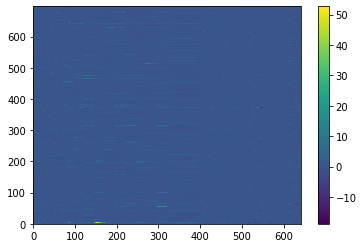

In [165]:
import matplotlib.pyplot as plt
plt.figure();
plt.pcolormesh(all_feat_concat_norm_trn); plt.colorbar()

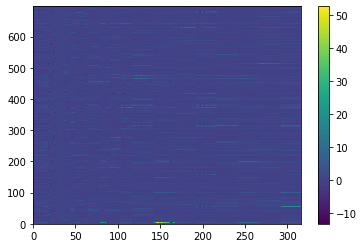

In [174]:
import matplotlib.pyplot as plt
plt.figure();
plt.pcolormesh(all_feat_concat_norm_trn[:,4:320]); plt.colorbar()

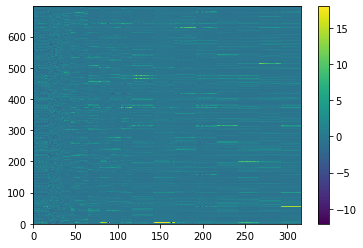

In [173]:
import matplotlib.pyplot as plt
plt.figure();
plt.pcolormesh(all_feat_concat_norm_val[:,4:320]); plt.colorbar()

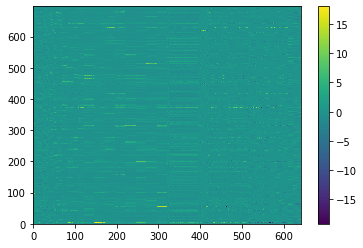

In [166]:
import matplotlib.pyplot as plt
plt.figure();
plt.pcolormesh(all_feat_concat_norm_val); plt.colorbar()

In [59]:
# old method

_feature_extractor.clear_big_features()
        
for mm in range(170,172):
#         for mm in range(n_prfs):
#             if mm>1 and debug:
#                 break
    print('Getting features for prf %d: [x,y,sigma] is [%.2f %.2f %.4f]'%(mm, prf_models[mm,0],  prf_models[mm,1],  prf_models[mm,2] ))
    # all_feat_concat is size [ntrials x nfeatures]
    # nfeatures may be less than n_features_max, because n_features_max is the largest number possible for any pRF.
    # feature_inds_defined is length max_features, and tells which of the features in max_features are includes in features.
    all_feat_concat_OLD, feature_inds_defined_OLD = _feature_extractor(images, prf_models[mm,:], mm, fitting_mode=False)

    pred_models_OLD[:,feature_inds_defined,mm] = torch_utils.get_value(all_feat_concat_OLD)
    feature_inds_defined_each_prf_OLD[:,mm] = feature_inds_defined_OLD

_feature_extractor.clear_big_features()


Clearing precomputed features from memory.
Getting features for prf 170: [x,y,sigma] is [0.03 -0.09 0.0400]
Loading pre-computed features for models [150 - 199] from /user_data/mmhender/features/pyramid_texture/S1_features_each_prf_4ori_4sf.h5py
Took 90.93706 seconds to load file
Size of features array for this batch is:
(697, 641, 50)
Index into batch for prf 170: 20
Size of features array for this image set and prf is:
(697, 641)
Final size of features concatenated is [697 x 641]
Feature types included are:
['pixel_stats', 'mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', 'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', 'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', 'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']
Final size of features concatenated is [697 x 641]
Final si

In [61]:
pred_models_OLD.shape

(697, 641, 875)

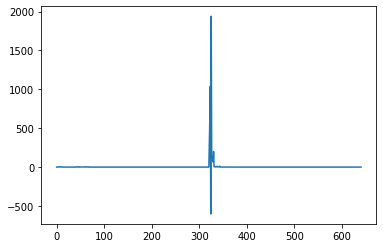

In [65]:
import matplotlib.pyplot as plt
plt.figure();
# plt.plot(pred_models[0,:,171])
plt.plot(pred_models_OLD[0,:,171])

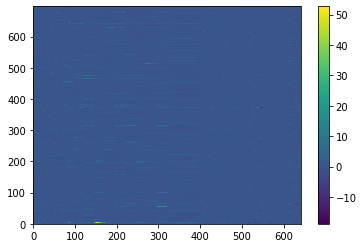

In [128]:
import matplotlib.pyplot as plt
plt.figure();
plt.pcolormesh(all_feat_concat); plt.colorbar()

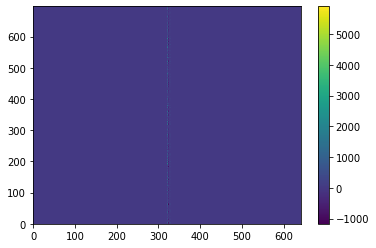

In [129]:
import matplotlib.pyplot as plt
plt.figure();
plt.pcolormesh(all_feat_concat_OLD); plt.colorbar()

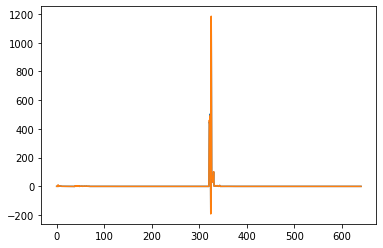

In [149]:
plt.figure();
val_mean = np.mean(all_feat_concat_OLD.detach().cpu().numpy(), axis=0)
trn_mean = features_mt[vind,:]
plt.plot(val_mean)
plt.plot(trn_mean)

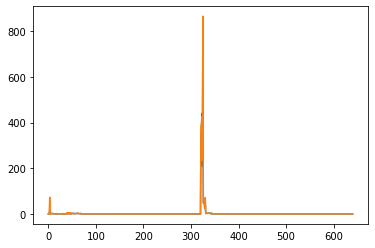

In [150]:
plt.figure();
val_std = np.std(all_feat_concat_OLD.detach().cpu().numpy(), axis=0)
trn_std = features_st[vind,:]
plt.plot(val_std)
plt.plot(trn_std)

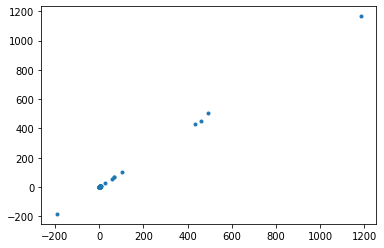

In [151]:
plt.figure();
plt.plot(trn_mean, val_mean, '.')

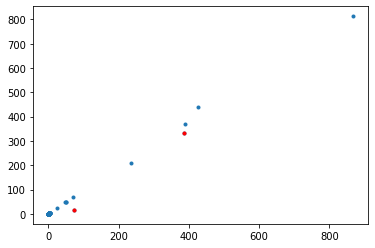

In [164]:
plt.figure();
plt.plot(trn_std, val_std, '.')
plt.plot(trn_std[[3,321]], val_std[[3,321]], '.',color='r')

In [161]:
np.flip(np.argsort(np.abs(trn_std-val_std)))[0:2]

array([  3, 321])

In [156]:
trn_std[3]

72.6994

In [157]:
val_std[3]

16.283298

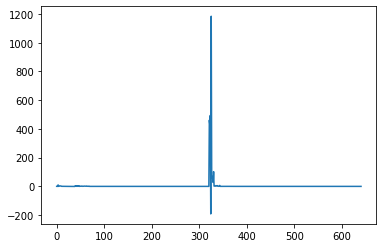

In [98]:
plt.figure();
plt.plot(trn_mean)

In [93]:
all_feat_concat_OLD.shape

torch.Size([697, 641])

In [57]:
all_feat_concat.shape

(697, 641)

In [69]:
rv = np.arange(19644, 19646)
lv = len(rv)
print('Getting predictions for voxels [%d-%d] of %d'%(rv[0],rv[-1],n_voxels))

Getting predictions for voxels [19644-19645] of 19738


In [133]:
# new method
pp=0

print('\nEvaluating version %d of %d: %s'%(pp, n_partial_versions, partial_version_names[pp]))

# masks describes the indices of the features that are included in this partial model
# n_features_max in length
features_to_use = masks[:,pp]==1
print('Includes %d features'%np.sum(features_to_use))

# here is where we choose the right set of features for each voxel, based
# on its fitted prf.
# [trials x features x voxels]
features_full = pred_models[:,:,best_model_inds[rv,pp]]

# Take out the relevant features now
features_full = features_full[:,features_to_use,:]
# Note there may be some zeros in this matrix, if we used fewer than the 
# max number of features.
# But they are zero in weight matrix too, so turns out ok.

_weights = torch_utils._to_torch(weights[rv,:,pp], device=device)   
_weights = _weights[:, features_to_use]
_bias = torch_utils._to_torch(bias[rv,pp], device=device)

print('number of zeros:')
print(np.sum(features_full[0,:,0]==0))

print('size of weights is:')
print(_weights.shape)

pred_block = np.full(fill_value=0, shape=(n_trials, lv), dtype=dtype)

# Now looping over validation set trials in batches
for rt, lt in numpy_utils.iterate_range(0, n_trials, sample_batch_size):

    _features = torch_utils._to_torch(features_full[rt,:,:], device=device)
    # features is [#samples, #features, #voxels]
    # swap dims to [#voxels, #samples, features]
    _features = torch.transpose(torch.transpose(_features, 0, 2), 1, 2)
    # weights is [#voxels, #features]
    # _r will be [#voxels, #samples, 1] - then [#samples, #voxels]
    _r = torch.squeeze(torch.bmm(_features, torch.unsqueeze(_weights, 2)), dim=2).t() 

    if _bias is not None:
        _r = _r + torch.tile(torch.unsqueeze(_bias, 0), [_r.shape[0],1])

    pred_block[rt] = torch_utils.get_value(_r) 

# Making sure to save these so that we can get stacking performance later.
pred_voxel_data[:,rv,pp] = pred_block

# Now for this batch of voxels and this partial version of the model, measure performance.
val_cc[rv,pp] = stats_utils.get_corrcoef(voxel_data[:,rv], pred_block)
val_r2[rv,pp] = stats_utils.get_r2(voxel_data[:,rv], pred_block)



Evaluating version 0 of 3: full_model
Includes 641 features
number of zeros:
0
size of weights is:
torch.Size([2, 641])


In [79]:
features_full.shape

(697, 641, 2)

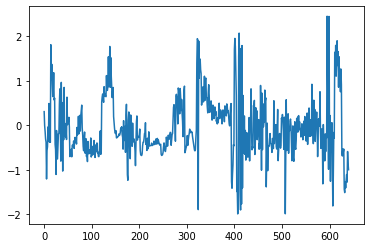

In [148]:
plt.figure();
plt.plot(features_full[9,:,1])

In [134]:
val_r2[vind,0]

-14.152167

In [72]:
rv

array([19644, 19645])

In [136]:
stats_utils.get_r2(voxel_data[:,vind], pred_block[:,1])

-14.152167792359611

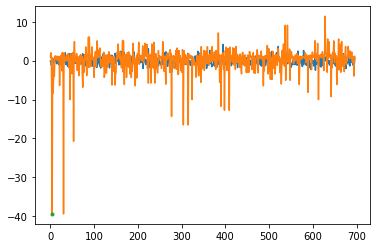

In [135]:
plt.figure();
plt.plot(voxel_data[:,vind])
plt.plot(pred_block[:,1])
plt.plot(ti, pred_block[ti,1],'.')

In [137]:
ti = np.argmin(pred_block[:,1])
ti

4

In [124]:
from __future__ import division
import sys
import time
import numpy as np
import copy
import torch
from cvxopt import matrix, solvers
import scipy.stats

from utils import numpy_utils, torch_utils, stats_utils


def validate_fwrf_model(best_params, prf_models, voxel_data, images, _feature_extractor, zscore=False,\
                       sample_batch_size=100, voxel_batch_size=100, debug=False, dtype=np.float32):
    
    """ 
    Evaluate trained model, leaving out a subset of features at a time.
    """
    
    params = best_params
    device = _feature_extractor.device
    
    n_trials, n_voxels = len(images), len(params[0])
    n_prfs = prf_models.shape[0]
    n_features = params[1].shape[1]  
    n_voxels = np.shape(voxel_data)[1]

    best_models, weights, bias, features_mt, features_st, best_model_inds = params
    masks, partial_version_names = _feature_extractor.get_partial_versions()
    masks = np.transpose(masks)    
    n_features_max = _feature_extractor.max_features
    n_partial_versions = len(partial_version_names)
    
    if zscore:
        if hasattr(_feature_extractor, 'zgroup_labels') and \
                        _feature_extractor.zgroup_labels is not None:
            zscore_in_groups = True
            zgroup_labels = _feature_extractor.zgroup_labels
            print('will z-score columns in groups')
        else:
            zscore_in_groups = False
            print('will z-score each column')
    else:
        print('will not z-score')
    
    # val_cc is the correlation coefficient bw real and predicted responses across trials, for each voxel.
    val_cc  = np.zeros(shape=(n_voxels, n_partial_versions), dtype=dtype)
    val_r2 = np.zeros(shape=(n_voxels, n_partial_versions), dtype=dtype)

    pred_models = np.full(fill_value=0, shape=(n_trials, n_features_max, n_prfs), dtype=dtype)
    feature_inds_defined_each_prf = np.full(fill_value=0, shape=(n_features_max, n_prfs), dtype=bool)
    
    # Saving full trial-by-trial predictions for each voxel, each partial model.
    # Need these for stacking.
    pred_voxel_data = np.full(fill_value=0, shape=(n_trials, n_voxels, n_partial_versions), dtype=dtype)
    
    start_time = time.time()    
    with torch.no_grad(): # make sure local gradients are off to save memory
        
        # First gather features for all pRFs. There are fewer pRFs than voxels, so it is faster
        # to loop over pRFs first, then voxels.
        
        _feature_extractor.clear_big_features()
        
        for mm in range(170,172):
#         for mm in range(n_prfs):
#             if mm>1 and debug:
#                 break
            print('Getting features for prf %d: [x,y,sigma] is [%.2f %.2f %.4f]'%(mm, prf_models[mm,0],  prf_models[mm,1],  prf_models[mm,2] ))
            # all_feat_concat is size [ntrials x nfeatures]
            # nfeatures may be less than n_features_max, because n_features_max is the largest number possible for any pRF.
            # feature_inds_defined is length max_features, and tells which of the features in max_features are includes in features.
            all_feat_concat, feature_inds_defined = _feature_extractor(images, prf_models[mm,:], mm, fitting_mode=False)
            
            all_feat_concat = torch_utils.get_value(all_feat_concat)
            if zscore:
                if zscore_in_groups:
                    all_feat_concat = numpy_utils.zscore_in_groups(all_feat_concat, zgroup_labels)
                else:
                    tiled_mean = np.tile(features_mt[mm,:], [n_trials, 1])
                    tiled_std = np.tile(features_st[mm,:], [n_trials, 1])
                    all_feat_concat = (all_feat_concat - tiled_mean)/tiled_std
#                     all_feat_concat = scipy.stats.zscore(all_feat_concat, axis=0)
                # if any entries in std are zero or nan, this gives bad result - fix these now.
                # these bad entries will also be zero in weights, so doesn't matter. 
                # just want to avoid nans.
                all_feat_concat[np.isnan(all_feat_concat)] = 0.0 
                all_feat_concat[np.isinf(all_feat_concat)] = 0.0 
                        
            pred_models[:,feature_inds_defined,mm] = all_feat_concat
            feature_inds_defined_each_prf[:,mm] = feature_inds_defined
            
        _feature_extractor.clear_big_features()
        
        # Next looping over all voxels in batches.
        
#         vv=-1
        rv = np.arange(19644, 19646)
        lv = len(rv)
#         for rv, lv in numpy_utils.iterate_range(0, n_voxels, voxel_batch_size):
#             vv=vv+1
        print('Getting predictions for voxels [%d-%d] of %d'%(rv[0],rv[-1],n_voxels))

#             if vv>1 and debug:
#                 break

        # Looping over versions of model w different features set to zero (variance partition)
        for pp in range(n_partial_versions):

            print('\nEvaluating version %d of %d: %s'%(pp, n_partial_versions, partial_version_names[pp]))

            # masks describes the indices of the features that are included in this partial model
            # n_features_max in length
            features_to_use = masks[:,pp]==1
            print('Includes %d features'%np.sum(features_to_use))


            # here is where we choose the right set of features for each voxel, based
            # on its fitted prf.
            # [trials x features x voxels]
            features_full = pred_models[:,:,best_model_inds[rv,pp]]

            # Take out the relevant features now
            features_full = features_full[:,features_to_use,:]
            # Note there may be some zeros in this matrix, if we used fewer than the 
            # max number of features.
            # But they are zero in weight matrix too, so turns out ok.

            _weights = torch_utils._to_torch(weights[rv,:,pp], device=device)   
            _weights = _weights[:, features_to_use]
            _bias = torch_utils._to_torch(bias[rv,pp], device=device)

            print('number of zeros:')
            print(np.sum(features_full[0,:,0]==0))

            print('size of weights is:')
            print(_weights.shape)

            pred_block = np.full(fill_value=0, shape=(n_trials, lv), dtype=dtype)

            # Now looping over validation set trials in batches
            for rt, lt in numpy_utils.iterate_range(0, n_trials, sample_batch_size):

                _features = torch_utils._to_torch(features_full[rt,:,:], device=device)
                # features is [#samples, #features, #voxels]
                # swap dims to [#voxels, #samples, features]
                _features = torch.transpose(torch.transpose(_features, 0, 2), 1, 2)
                # weights is [#voxels, #features]
                # _r will be [#voxels, #samples, 1] - then [#samples, #voxels]
                _r = torch.squeeze(torch.bmm(_features, torch.unsqueeze(_weights, 2)), dim=2).t() 

                if _bias is not None:
                    _r = _r + torch.tile(torch.unsqueeze(_bias, 0), [_r.shape[0],1])

                pred_block[rt] = torch_utils.get_value(_r) 

            # Making sure to save these so that we can get stacking performance later.
            pred_voxel_data[:,rv,pp] = pred_block

            # Now for this batch of voxels and this partial version of the model, measure performance.
            val_cc[rv,pp] = stats_utils.get_corrcoef(voxel_data[:,rv], pred_block)
            val_r2[rv,pp] = stats_utils.get_r2(voxel_data[:,rv], pred_block)

            sys.stdout.flush()

    # any nans become zeros here.
    val_cc = np.nan_to_num(val_cc)
    val_r2 = np.nan_to_num(val_r2) 
    
    return val_cc, val_r2, pred_voxel_data


In [35]:
from __future__ import division
import sys
import time
import numpy as np
import copy
import torch
from cvxopt import matrix, solvers
import scipy.stats

from utils import numpy_utils, torch_utils, stats_utils


def validate_fwrf_model_TEST(best_params, prf_models, voxel_data, images, _feature_extractor, zscore=False,\
                       sample_batch_size=100, voxel_batch_size=100, debug=False, dtype=np.float32):
    
    """ 
    Evaluate trained model, leaving out a subset of features at a time.
    """
    
    params = best_params
    device = _feature_extractor.device
    
    n_trials, n_voxels = len(images), len(params[0])
    n_prfs = prf_models.shape[0]
    n_features = params[1].shape[1]  
    n_voxels = np.shape(voxel_data)[1]

    best_models, weights, bias, features_mt, features_st, best_model_inds = params
    masks, partial_version_names = _feature_extractor.get_partial_versions()
    masks = np.transpose(masks)    
    n_features_max = _feature_extractor.max_features
    n_partial_versions = len(partial_version_names)
    
    if zscore:
        if hasattr(_feature_extractor, 'zgroup_labels') and \
                        _feature_extractor.zgroup_labels is not None:
            zscore_in_groups = True
            zgroup_labels = _feature_extractor.zgroup_labels
            print('will z-score columns in groups')
        else:
            zscore_in_groups = False
            print('will z-score each column')
    else:
        print('will not z-score')
    
    # val_cc is the correlation coefficient bw real and predicted responses across trials, for each voxel.
    val_cc  = np.zeros(shape=(n_voxels, n_partial_versions), dtype=dtype)
    val_r2 = np.zeros(shape=(n_voxels, n_partial_versions), dtype=dtype)

    pred_models = np.full(fill_value=0, shape=(n_trials, n_features_max, n_prfs), dtype=dtype)
    feature_inds_defined_each_prf = np.full(fill_value=0, shape=(n_features_max, n_prfs), dtype=bool)
    
    # Saving full trial-by-trial predictions for each voxel, each partial model.
    # Need these for stacking.
    pred_voxel_data = np.full(fill_value=0, shape=(n_trials, n_voxels, n_partial_versions), dtype=dtype)
    
    start_time = time.time()    
    with torch.no_grad(): # make sure local gradients are off to save memory
        
        # First gather features for all pRFs. There are fewer pRFs than voxels, so it is faster
        # to loop over pRFs first, then voxels.
        
        _feature_extractor.clear_big_features()
        
        for mm in range(170,172):
#         for mm in range(n_prfs):
#             if mm>1 and debug:
#                 break
            print('Getting features for prf %d: [x,y,sigma] is [%.2f %.2f %.4f]'%(mm, prf_models[mm,0],  prf_models[mm,1],  prf_models[mm,2] ))
            # all_feat_concat is size [ntrials x nfeatures]
            # nfeatures may be less than n_features_max, because n_features_max is the largest number possible for any pRF.
            # feature_inds_defined is length max_features, and tells which of the features in max_features are includes in features.
            all_feat_concat, feature_inds_defined = _feature_extractor(images, prf_models[mm,:], mm, fitting_mode=False)
            
            all_feat_concat = torch_utils.get_value(all_feat_concat)
            if zscore:
                if zscore_in_groups:
                    all_feat_concat = numpy_utils.zscore_in_groups(all_feat_concat, zgroup_labels)
                else:
                    all_feat_concat = 
#                     all_feat_concat = scipy.stats.zscore(all_feat_concat, axis=0)
                # if any entries in std are zero or nan, this gives bad result - fix these now.
                # these bad entries will also be zero in weights, so doesn't matter. 
                # just want to avoid nans.
                all_feat_concat[np.isnan(all_feat_concat)] = 0.0 
                all_feat_concat[np.isinf(all_feat_concat)] = 0.0 
                        
            pred_models[:,feature_inds_defined,mm] = all_feat_concat
            feature_inds_defined_each_prf[:,mm] = feature_inds_defined
            
        _feature_extractor.clear_big_features()
        
        # Next looping over all voxels in batches.
        
#         vv=-1
        rv = np.arange(19644, 19646)
        lv = len(rv)
#         for rv, lv in numpy_utils.iterate_range(0, n_voxels, voxel_batch_size):
#             vv=vv+1
        print('Getting predictions for voxels [%d-%d] of %d'%(rv[0],rv[-1],n_voxels))

#             if vv>1 and debug:
#                 break

        # Looping over versions of model w different features set to zero (variance partition)
        for pp in range(n_partial_versions):

            print('\nEvaluating version %d of %d: %s'%(pp, n_partial_versions, partial_version_names[pp]))

            # masks describes the indices of the features that are included in this partial model
            # n_features_max in length
            features_to_use = masks[:,pp]==1
            print('Includes %d features'%np.sum(features_to_use))


            # here is where we choose the right set of features for each voxel, based
            # on its fitted prf.
            # [trials x features x voxels]
            features_full = pred_models[:,:,best_model_inds[rv,pp]]

            # Take out the relevant features now
            features_full = features_full[:,features_to_use,:]
            # Note there may be some zeros in this matrix, if we used fewer than the 
            # max number of features.
            # But they are zero in weight matrix too, so turns out ok.

            _weights = torch_utils._to_torch(weights[rv,:,pp], device=device)   
            _weights = _weights[:, features_to_use]
            _bias = torch_utils._to_torch(bias[rv,pp], device=device)

            print('number of zeros:')
            print(np.sum(features_full[0,:,0]==0))

            print('size of weights is:')
            print(_weights.shape)

            pred_block = np.full(fill_value=0, shape=(n_trials, lv), dtype=dtype)

            # Now looping over validation set trials in batches
            for rt, lt in numpy_utils.iterate_range(0, n_trials, sample_batch_size):

                _features = torch_utils._to_torch(features_full[rt,:,:], device=device)
                # features is [#samples, #features, #voxels]
                # swap dims to [#voxels, #samples, features]
                _features = torch.transpose(torch.transpose(_features, 0, 2), 1, 2)
                # weights is [#voxels, #features]
                # _r will be [#voxels, #samples, 1] - then [#samples, #voxels]
                _r = torch.squeeze(torch.bmm(_features, torch.unsqueeze(_weights, 2)), dim=2).t() 

                if _bias is not None:
                    _r = _r + torch.tile(torch.unsqueeze(_bias, 0), [_r.shape[0],1])

                pred_block[rt] = torch_utils.get_value(_r) 

            # Making sure to save these so that we can get stacking performance later.
            pred_voxel_data[:,rv,pp] = pred_block

            # Now for this batch of voxels and this partial version of the model, measure performance.
            val_cc[rv,pp] = stats_utils.get_corrcoef(voxel_data[:,rv], pred_block)
            val_r2[rv,pp] = stats_utils.get_r2(voxel_data[:,rv], pred_block)

            sys.stdout.flush()

    # any nans become zeros here.
    val_cc = np.nan_to_num(val_cc)
    val_r2 = np.nan_to_num(val_r2) 
    
    return val_cc, val_r2, pred_voxel_data


In [42]:
# from __future__ import division
import sys
import time
import numpy as np
import copy
import torch
from cvxopt import matrix, solvers

from utils import numpy_utils, torch_utils, stats_utils


def validate_fwrf_model_OLD(best_params, prf_models, voxel_data, images, _feature_extractor, \
                                   sample_batch_size=100, voxel_batch_size=100, debug=False, dtype=np.float32):
    
    """ 
    Evaluate trained model, leaving out a subset of features at a time.
    """
    
    params = best_params
    device = _feature_extractor.device
    
    n_trials, n_voxels = len(images), len(params[0])
    n_prfs = prf_models.shape[0]
    n_features = params[1].shape[1]  
    n_voxels = np.shape(voxel_data)[1]

    best_models, weights, bias, features_mt, features_st, best_model_inds = params
    masks, partial_version_names = _feature_extractor.get_partial_versions()
    masks = np.transpose(masks)    
    n_features_max = _feature_extractor.max_features
    n_partial_versions = len(partial_version_names)
    
    # val_cc is the correlation coefficient bw real and predicted responses across trials, for each voxel.
    val_cc  = np.zeros(shape=(n_voxels, n_partial_versions), dtype=dtype)
    val_r2 = np.zeros(shape=(n_voxels, n_partial_versions), dtype=dtype)

    pred_models = np.full(fill_value=0, shape=(n_trials, n_features_max, n_prfs), dtype=dtype)
    feature_inds_defined_each_prf = np.full(fill_value=0, shape=(n_features_max, n_prfs), dtype=bool)
    
    # Saving full trial-by-trial predictions for each voxel, each partial model.
    # Need these for stacking.
    pred_voxel_data = np.full(fill_value=0, shape=(n_trials, n_voxels, n_partial_versions), dtype=dtype)
    
    start_time = time.time()    
    with torch.no_grad(): # make sure local gradients are off to save memory
        
        # First gather texture features for all pRFs.
        
        _feature_extractor.clear_big_features()
        
        for mm in range(170,172):
#         for mm in range(n_prfs):
#             if mm>1 and debug:
#                 break
            print('Getting features for prf %d: [x,y,sigma] is [%.2f %.2f %.4f]'%(mm, prf_models[mm,0],  prf_models[mm,1],  prf_models[mm,2] ))
            # all_feat_concat is size [ntrials x nfeatures]
            # nfeatures may be less than n_features_max, because n_features_max is the largest number possible for any pRF.
            # feature_inds_defined is length max_features, and tells which of the features in max_features are includes in features.
            all_feat_concat, feature_inds_defined = _feature_extractor(images, prf_models[mm,:], mm, fitting_mode=False)
            
            pred_models[:,feature_inds_defined,mm] = torch_utils.get_value(all_feat_concat)
            feature_inds_defined_each_prf[:,mm] = feature_inds_defined
            
        _feature_extractor.clear_big_features()
        
        rv = np.arange(19644, 19646)
        lv = len(rv)
#         vv=-1
#         ## Looping over voxels here in batches, will eventually go through all.
#         for rv, lv in numpy_utils.iterate_range(0, n_voxels, voxel_batch_size):
#             vv=vv+1
        print('Getting predictions for voxels [%d-%d] of %d'%(rv[0],rv[-1],n_voxels))

#         if vv>1 and debug:
#             break

        # Looping over versions of model w different features set to zero (variance partition)
        for pp in range(n_partial_versions):

            print('\nEvaluating version %d of %d: %s'%(pp, n_partial_versions, partial_version_names[pp]))

            # masks describes the indices of the features that are included in this partial model
            # n_features_max in length
            features_to_use = masks[:,pp]==1
            print('Includes %d features'%np.sum(features_to_use))

            # [trials x features x voxels]
            features_full = pred_models[:,:,best_model_inds[rv,pp]]
            # Take out the relevant features now
            features_full = features_full[:,features_to_use,:]
            # Note there may be some zeros in this matrix, if we used fewer than the max number of features.
            # But they are zero in weight matrix too, so turns out ok.

            _weights = torch_utils._to_torch(weights[rv,:,pp], device=device)   
            _weights = _weights[:, features_to_use]
            _bias = torch_utils._to_torch(bias[rv,pp], device=device)

            print('number of zeros:')
            print(np.sum(features_full[0,:,0]==0))

            print('size of weights is:')
            print(_weights.shape)

            if features_mt is not None:
                _features_m = torch_utils._to_torch(features_mt[rv,:], device=device)
                _features_m = _features_m[:,features_to_use]
            if features_st is not None:
                _features_s = torch_utils._to_torch(features_st[rv,:], device=device)
                _features_s = _features_s[:,features_to_use]

            pred_block = np.full(fill_value=0, shape=(n_trials, lv), dtype=dtype)

            # Now looping over validation set trials in batches
            for rt, lt in numpy_utils.iterate_range(0, n_trials, sample_batch_size):

                _features = torch_utils._to_torch(features_full[rt,:], device=device) # trials x features
                if features_mt is not None:    
                    # features_m is [nvoxels x nfeatures] - need [trials x features x voxels]
                    _features = _features - torch.tile(torch.unsqueeze(_features_m, dim=0), [_features.shape[0], 1, 1]).moveaxis([1],[2])

                if features_st is not None:
                    _features = _features/torch.tile(torch.unsqueeze(_features_s, dim=0), [_features.shape[0], 1, 1]).moveaxis([1],[2])
                    # if any entries in std are zero or nan, this gives bad result - fix these now.
                    # these bad entries will also be zero in weights, so doesn't matter. just want to avoid nans.
                    _features[torch.isnan(_features)] = 0.0 
                    _features[torch.isinf(_features)] = 0.0

                # features is [#samples, #features, #voxels] - swap dims to [#voxels, #samples, features]
                _features = torch.transpose(torch.transpose(_features, 0, 2), 1, 2)
                # weights is [#voxels, #features]
                # _r will be [#voxels, #samples, 1] - then [#samples, #voxels]

                _r = torch.squeeze(torch.bmm(_features, torch.unsqueeze(_weights, 2)), dim=2).t() 

                if _bias is not None:
                    _r = _r + torch.tile(torch.unsqueeze(_bias, 0), [_r.shape[0],1])

                pred_block[rt] = torch_utils.get_value(_r) 

            # Making sure to save these so that we can get stacking performance later.
            pred_voxel_data[:,rv,pp] = pred_block

            # Now for this batch of voxels and this partial version of the model, measure performance.
            val_cc[rv,pp] = stats_utils.get_corrcoef(voxel_data[:,rv], pred_block)
            val_r2[rv,pp] = stats_utils.get_r2(voxel_data[:,rv], pred_block)

            sys.stdout.flush()

    # any nans become zeros here.
    val_cc = np.nan_to_num(val_cc)
    val_r2 = np.nan_to_num(val_r2) 
    
    return val_cc, val_r2, pred_voxel_data



In [122]:
import sys
import time
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.init as I
import torch.nn.functional as F
import torch.optim as optim

from utils import numpy_utils, torch_utils, texture_utils

"""
General code for fitting a 'feature weighted receptive field' model to fmri data - looping over many candidate pRF 
models for each voxel, find a set of weights that best predict its responses based on feature space of interest.
Can work for many different types of feature spaces, feature extraction implemented with nn.Module.

Original source of some of this code is the github repository:
https://github.com/styvesg/nsd
It was modified by MH to work for this project.
"""


def _cofactor_fn_cpu(_x, lambdas):
    '''
    Generating a matrix needed to solve ridge regression model for each lambda value.
    Ridge regression (Tikhonov) solution is :
    w = (X^T*X + I*lambda)^-1 * X^T * Y
    This func will return (X^T*X + I*lambda)^-1 * X^T. 
    So once we have that, can just multiply by training data (Y) to get weights.
    returned size is [nLambdas x nFeatures x nTrials]
    This version makes sure that the torch inverse operation is done on the cpu, and in floating point-64 precision.
    Otherwise get bad results for small lambda values. This seems to be a torch-specific bug, noted around May 2021.
    
    '''
    device_orig = _x.device
    type_orig = _x.dtype
    # switch to this specific format which works with inverse
    _x = _x.to('cpu').to(torch.float64)
    _f = torch.stack([(torch.mm(torch.t(_x), _x) + torch.eye(_x.size()[1], device='cpu', dtype=torch.float64) * l).inverse() for l in lambdas], axis=0) 
    
    # [#lambdas, #feature, #feature] 
    cof = torch.tensordot(_f, _x, dims=[[2],[1]]) # [#lambdas, #feature, #sample]
    
    # put back to whatever way it was before, so that we can continue with other operations as usual
    return cof.to(device_orig).to(type_orig)



def _loss_fn(_cofactor, _vtrn, _xout, _vout):
    '''
    Calculate loss given "cofactor" from cofactor_fn, training data, held-out design matrix, held out data.
    returns weights (betas) based on equation
    w = (X^T*X + I*lambda)^-1 * X^T * Y
    also returns loss for these weights w the held out data. SSE is loss func here.
    '''

    _beta = torch.tensordot(_cofactor, _vtrn, dims=[[2], [0]]) # [#lambdas, #feature, #voxel]
    _pred = torch.tensordot(_xout, _beta, dims=[[1],[1]]) # [#samples, #lambdas, #voxels]
    _loss = torch.sum(torch.pow(_vout[:,None,:] - _pred, 2), dim=0) # [#lambdas, #voxels]
    return _beta, _loss, _pred



def fit_fwrf_model(images, voxel_data, _feature_extractor, prf_models, lambdas, best_model_each_voxel=None,\
                   zscore=False, add_bias=False, voxel_batch_size=100, holdout_size=100, \
                       shuffle=True, shuff_rnd_seed=0, device=None, dtype=np.float32, debug=False):
    
    """
    Solve for encoding model weights using ridge regression.
    Inputs:
        images: the training images, [n_trials x 1 x height x width]
            OR for models where features were pre-computed, this is a list of indices [n_trials,] into the 10,000 long feature array.
        voxel_data: the training voxel data, [n_trials x n_voxels]
        _feature_extractor_fn: module that maps from images to model features
        prf_models: the list of possible pRFs to test, columns are [x, y, sigma]
        lambdas: ridge lambda parameters to test
        zscore: want to zscore each column of feature matrix before fitting?
        add_bias: add a column of ones to feature matrix, for an additive bias?
        voxel_batch_size: how many voxels to use at a time for model fitting
        holdout_size: how many training trials to hold out for computing loss/lambda selection?
        shuffle: do we shuffle training data order before holding trials out?      
        shuff_rnd_seed: if we do shuffle training data (shuffle=True), what random seed to use? if zero, choose a new random seed in this code.
        device: what device to use? cpu/cuda
        debug: want to run a shortened version of this, to test it?
    Outputs:
        best_losses: loss value for each voxel (with best pRF and best lambda), eval on held out set
        best_lambdas: best lambda for each voxel (chosen based on loss w held out set)
        best_params: 
            [0] best pRF for each voxel [x,y,sigma]
            [1] best weights for each voxel/feature
            [2] if add_bias=True, best bias value for each voxel
            [3] if zscore=True, the mean of each feature before z-score
            [4] if zscore=True, the std of each feature before z-score
            [5] index of the best pRF for each voxel (i.e. index of row in "prf_models")
        
    """

    if device is None:
        device=torch.device('cpu:0')

    print ('dtype = %s' % dtype)
    print ('device = %s' % device)

    n_trials = len(images)
    n_prfs = len(prf_models)
    n_voxels = voxel_data.shape[1]   

    # Get train/holdout splits.
    # Held-out data here is used for lamdba selection.
    # This is the inner part of nested cross-validation; there is another portion of data ('val')
    # which never enters this function.
    trn_size = n_trials - holdout_size
    assert trn_size>0, 'Training size needs to be greater than zero'
    print ('trn_size = %d (%.1f%%)' % (trn_size, float(trn_size)*100/len(voxel_data)))
    order = np.arange(len(voxel_data), dtype=int)
    if shuffle:
        if shuff_rnd_seed==0:
            print('Computing a new random seed')
            shuff_rnd_seed = int(time.strftime('%M%H%d', time.localtime()))
        print('Seeding random number generator: seed is %d'%shuff_rnd_seed)
        np.random.seed(shuff_rnd_seed)
        np.random.shuffle(order)
        
    images = images[order]
    
    train_trial_order = order[:trn_size]
    holdout_trial_order = order[trn_size:]

    trn_data = copy.deepcopy(voxel_data[train_trial_order,:])
    out_data = copy.deepcopy(voxel_data[holdout_trial_order,:])
    
    
    # Here is where any model-specific additional initialization steps are done
    # Includes initializing pca params arrays, if doing pca
    if len(images.shape)>1:
        image_size = images.shape[2:4]
    else:
        image_size = None
    _feature_extractor.init_for_fitting(image_size, prf_models, dtype)
    max_features = _feature_extractor.max_features

    # Decide whether to do any "partial" versions of the models (leaving out subsets of features)
    # Purpose is for variance partition
    masks, partial_version_names = _feature_extractor.get_partial_versions()
    n_partial_versions = len(partial_version_names) # will be one if skipping varpart
    if add_bias:
        masks = np.concatenate([masks, np.ones([masks.shape[0],1])], axis=1) # always include intercept 
    masks = np.transpose(masks)
    # masks is [n_features_total (including intercept) x n_partial_versions]

    # Initialize arrays to store model fitting params
    best_w_params = np.zeros(shape=(n_voxels, max_features ,n_partial_versions), dtype=dtype)
    best_prf_models = np.full(shape=(n_voxels,n_partial_versions), fill_value=-1, dtype=int)   
    best_lambdas = np.full(shape=(n_voxels,n_partial_versions), fill_value=-1, dtype=int)
    best_losses = np.full(fill_value=np.inf, shape=(n_voxels,n_partial_versions), dtype=dtype)

    # Initialize arrays to store the trial-wise predictions (need these for stacking)
    # Using JUST the held out trials here so the errors are always cross-validated
    best_train_holdout_preds = np.zeros(shape=(n_voxels, holdout_size, n_partial_versions), dtype=dtype)

    # Additional params that are optional
    if add_bias:
        best_w_params = np.concatenate([best_w_params, np.zeros(shape=(n_voxels,1,n_partial_versions), dtype=dtype)], axis=1)

    if zscore:
        if hasattr(_feature_extractor, 'zgroup_labels') and \
                        _feature_extractor.zgroup_labels is not None:
            zscore_in_groups = True
            features_mean = None
            features_std = None
            zgroup_labels = _feature_extractor.zgroup_labels
            print('will z-score columns in groups')
        else:
            zscore_in_groups = False
            features_mean = np.zeros(shape=(n_prfs, max_features), dtype=dtype)
            features_std  = np.zeros(shape=(n_prfs, max_features), dtype=dtype)
            print('will z-score each column')
    else:
        features_mean = None
        features_std = None
        print('will not z-score')

    start_time = time.time()
    vox_loop_time = 0

    print ('---------------------------------------\n')
    
    with torch.no_grad(): # make sure local gradients are off to save memory
        
        # Looping over prf_models (here prf_models are different spatial RF definitions)
#         for m,(x,y,sigma) in enumerate(prf_models):
        for m in np.arange(170,172):
            x,y,sigma = prf_models[m]
#             if debug and m>1:
#                 break
                
            print('\nGetting features for prf %d: [x,y,sigma] is [%.2f %.2f %.4f]'%(m, \
                                                        prf_models[m,0],  prf_models[m,1],  prf_models[m,2]))

            t = time.time()            

            # Get features for the desired pRF, across all trn set image  
            # Features is size [ntrials x nfeatures]
            # nfeatures may be less than max_features, because max_features is the largest number possible for any pRF.
            # feature_inds_defined is length max_features, and tells which of the features in max_features 
            # are included in features.
            features, feature_inds_defined = _feature_extractor(images, (x,y,sigma), m, fitting_mode=True)
            features = features.detach().cpu().numpy() 
            
            elapsed = time.time() - t

            n_features_actual = features.shape[1]
            
            if zscore:  
                if zscore_in_groups:
                    features = numpy_utils.zscore_in_groups(features, zgroup_labels)
                else:
                    # otherwise do each column separately, this is usual way
                    features_m = np.mean(features, axis=0, keepdims=True) #[:trn_size]
                    features_s = np.std(features, axis=0, keepdims=True) + 1e-6          
                    features -= features_m
                    features /= features_s    
                    features_mean[m,feature_inds_defined] = features_m
                    features_std[m,feature_inds_defined] = features_s

            if add_bias:
                features = np.concatenate([features, np.ones(shape=(len(features), 1), dtype=dtype)], axis=1)
                feature_inds_defined = np.concatenate((feature_inds_defined, [True]), axis=0)
                
            trn_features = features[:trn_size,:]
            out_features = features[trn_size:,:]
            
            
            # Going to keep track of whether current prf is better than running best, for each voxel.
            # This is for the full model only.
            # Will use this to make sure for each partial model, we end up saving the params for the 
            # prf that was best w full model.
            if best_model_each_voxel is None:
                full_model_improved = np.zeros((n_voxels,),dtype=bool)
                voxels_to_fit = np.arange(0, n_voxels)
            else:
                voxels_to_fit = np.where(best_model_each_voxel==m)[0]
            
            if len(voxels_to_fit)==0:
                print('No voxels have this pRF saved as their best model, skipping it.')
                continue
            
            
            n_voxels_to_fit = len(voxels_to_fit)            
            n_voxel_batches = int(np.ceil(n_voxels_to_fit/voxel_batch_size))

            
            # Looping over versions of model w different features set to zero (variance partition)
            for pp in range(n_partial_versions):

                print('\nFitting version %d of %d: %s, '%(pp, n_partial_versions, partial_version_names[pp]))

                # nonzero_inds_full is length max_features (or max_features+1 if bias=True)
                # same size as the final params matrices will be.
                nonzero_inds_full = np.logical_and(masks[:,pp], feature_inds_defined)             
                # nonzero_inds_full is restricted to just indices that are defined for this prf - ie same size as features.
                nonzero_inds_short = masks[feature_inds_defined,pp]==1
        
                # Send matrices to gpu    
                _xtrn = torch_utils._to_torch(trn_features[:, nonzero_inds_short], device=device)
                _xout = torch_utils._to_torch(out_features[:, nonzero_inds_short], device=device)   

                # Do part of the matrix math involved in ridge regression optimization out of the loop, 
                # because this part will be same for all the voxels.
                _cof = _cofactor_fn_cpu(_xtrn, lambdas = lambdas) 

                # Now looping over batches of voxels (only reason is because can't store all in memory at same time)
                vox_start = time.time()

#                 for vi in range(n_voxel_batches):
                for vi in np.arange(196, 198):
        
                    vinds = np.arange(voxel_batch_size*vi, np.min([voxel_batch_size*(vi+1), n_voxels_to_fit]))
                    rv = voxels_to_fit[vinds]
                    print(rv)
                    lv = len(vinds)

                    sys.stdout.write('\rfitting model %4d of %-4d, voxel batch %d of %d'%(m, n_prfs, vi, n_voxel_batches))
                    if best_model_each_voxel is not None:
                        print(vinds)
                        print(rv)
                    
                    # Send matrices to gpu
                    _vtrn = torch_utils._to_torch(trn_data[:,rv], device=device)
                    _vout = torch_utils._to_torch(out_data[:,rv], device=device)

                    # Here is where optimization happens - relatively simple matrix math inside loss fn.
                    _betas, _loss, _pred_out = _loss_fn(_cof, _vtrn, _xout, _vout) 
                    #   [#lambda, #feature, #voxel, ], [#lambda, #voxel], [trials x lambdas x voxels]
                    # Keep trial-by-trial predictions for each held-out set trial (need for stacking)
                    pred_out = torch_utils.get_value(_pred_out) 
                
                    # choose best lambda value and the loss that went with it.
                    _loss_values, _lambda_index = torch.min(_loss, dim=0)
                    loss_values, lambda_index = torch_utils.get_value(_loss_values), torch_utils.get_value(_lambda_index)
                    betas = torch_utils.get_value(_betas)
                    
                    if best_model_each_voxel is None:
                        
                        if pp==0:

                            # comparing this loss to the other prf_models for each voxel (e.g. the other RF position/sizes)
                            assert(partial_version_names[pp]=='full_model' or \
                                   partial_version_names[pp]=='full_combined_model')               
                            imp = loss_values<best_losses[rv,pp]
                            full_model_improved[rv] = imp

                        else:

                            # for the partial models we don't actually care which pRF was best for the partial model itself,
                            # just using which pRF is best for the full model. This way pRF is always the same even when 
                            # leaving a set of features out.
                            imp = full_model_improved[rv]

                    else:
                        
                        imp = np.ones((lv,))==1

                    if np.sum(imp)>0:

                        # for whichever voxels had improvement relative to previous prf_models, save parameters now
                        # this means we won't have to save all params for all prf_models, just best.
                        arv = np.array(rv)[imp]

                        lambda_inds = lambda_index[imp]
                        best_lambdas[arv,pp] = lambda_inds
                        best_losses[arv,pp] = loss_values[imp]                        
                        best_prf_models[arv,pp] = m
#                         if zscore and not zscore_in_groups and pp==0:
                            
#                             # only need to update the mean/std if we're working with the full model, 
#                             # because those will be same for all partial versions.
#                             fmean_tmp = copy.deepcopy(features_mean[arv,:])
#                             fstd_tmp = copy.deepcopy(features_std[arv,:])
#                             fmean_tmp[:,nonzero_inds_full[0:-1]] = features_m[0,nonzero_inds_short[0:-1]] 
#                             # broadcast over updated voxels
#                             fmean_tmp[:,~nonzero_inds_full[0:-1]] = 0.0
#                             fstd_tmp[:,nonzero_inds_full[0:-1]] = features_s[0,nonzero_inds_short[0:-1]] 
#                             # broadcast over updated voxels
#                             fstd_tmp[:,~nonzero_inds_full[0:-1]] = 0.0
#                             features_mean[arv,:] = fmean_tmp
#                             features_std[arv,:] = fstd_tmp
                            
                        # taking the weights associated with the best lambda value
                        # remember that they won't fill entire matrix, rest of values stay at zero
                        best_w_tmp = copy.deepcopy(best_w_params[arv,:,pp])
                        best_w_tmp[:,nonzero_inds_full] = numpy_utils.select_along_axis(betas[:,:,imp], lambda_inds, \
                                                                                        run_axis=2, choice_axis=0).T
                        best_w_tmp[:,~nonzero_inds_full] = 0.0 # make sure to fill zeros here
                        best_w_params[arv,:,pp] = best_w_tmp
                        
                        # Save the trialwise predictions for all trials in their original order.
                        # Choosing predictions from whichever lambda was best.
                        best_train_holdout_preds[arv,:,pp] = numpy_utils.select_along_axis(pred_out[:,:,imp], \
                                                                               lambda_inds, run_axis=2, choice_axis=1).T;

                vox_loop_time += (time.time() - vox_start)
                elapsed = (time.time() - vox_start)
                sys.stdout.flush()

    # Print information about how fitting went...
    total_time = time.time() - start_time
    inv_time = total_time - vox_loop_time
    return_params = [best_w_params[:,0:max_features,:],]
    if add_bias:
        return_params += [best_w_params[:,-1,:],]
    else: 
        return_params += [None,]
    print ('\n---------------------------------------')
    print ('total time = %fs' % total_time)
    print ('total throughput = %fs/voxel' % (total_time / n_voxels))
    print ('voxel throughput = %fs/voxel' % (vox_loop_time / n_voxels))
    print ('setup throughput = %fs/model' % (inv_time / n_prfs))
    
    # This step clears the big feature maps for training data from feature extractor (no longer needed)
    _feature_extractor.clear_big_features()
    
    best_params = [prf_models[best_prf_models],]+return_params+[features_mean, features_std]+[best_prf_models]
    sys.stdout.flush()

    return best_losses, best_lambdas, best_params, best_train_holdout_preds, holdout_trial_order